In [1]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

2023-09-23 12:01:43.702109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 12:01:45.737514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def read_data(filename = '../data/daily_barbacena.csv'):
    df_temp = pd.read_csv(
        filename,
        sep=',',
        parse_dates=['Timestamp'],
        index_col=['Timestamp'])

    init_index = lambda _df: _df[_df.RADIATION != 0].index[0]

    df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
        .resample('D') \
        .agg({'RADIATION': np.sum, 'TEMP': np.mean, 'HUMIDITY_h': np.mean})\
        .replace(0, np.nan)

    return df.loc[df.index >= init_index(df)]

def interpolate_filler(data):
    return data.interpolate(method ='linear', limit_direction ='backward')

def fill_df(dataframe, filler):
    data = {}
    for column in dataframe.columns:
        data[column] = filler(dataframe[column])
    return pd.DataFrame(data=data, index=dataframe.index.values)

def windowing(dataframe, step_back, step_front) -> (np.array, np.array):
    dataset = dataframe.values
    x, y = [], []
    for i in range(len(dataset) - step_back - step_front):
        j = (i + step_back)
        x.append(dataset[i:j])
        y.append(dataset[j:(j+step_front), 0])

    return np.array(x), np.array(y)

def split_data(x, y, length, ratio=0.8):
    train_size = int(length * 0.9)
    _train_x, _train_y = x[0:train_size], y[0:train_size].reshape(y[0:train_size].shape[0],)
    _test_x, _test_y = x[train_size:], y[train_size:].reshape(y[train_size:].shape[0],)
    return _train_x, _train_y, _test_x, _test_y

def show_error_metrics(real, pred):
    r2 = r2_score(real, pred)
    mse = mean_squared_error(real, pred)
    rmse = sqrt(mean_squared_error(real, pred))
    mae = mean_absolute_error(real, pred)
    mape = mean_absolute_percentage_error(real, pred)

    print('Test R2: %.3f' % r2)
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print('Test MAE: %.3f' % mae)
    print('Test MAPE: %.3f' % mape)

In [3]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units',
                                       min_value=32,
                                       max_value=512,
                                       step=32),
                          return_sequences=True,
                          input_shape=(5, 3)))
    model.add(layers.Dropout(rate=hp.Float(
        'dropout',
        min_value=0.0,
        max_value=0.5,
        default=0.25,
        step=0.05,
    )))
    model.add(layers.LSTM(units=hp.Int('units_2',
                                       min_value=32,
                                       max_value=512,
                                       step=32)))
    model.add(layers.Dense(1, activation=hp.Choice('activation', ['relu', 'sigmoid'])))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])))
    return model

def model_search(
        name,
        train_x,
        train_y,
        max_trials=10,
        executions_per_trial=1,
        epochs=10,
        validation_split=0.3
):
    tuner = RandomSearch(
        build_model,
        seed=13418236482,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='models',
        project_name=name)

    tuner.search_space_summary()

    tuner.search(train_x, train_y,
                 epochs=epochs,
                 validation_split=validation_split)

    return tuner.get_best_hyperparameters()[0]

In [2]:
class Scaler:
    scales: {}
    df: pd.DataFrame
    df_scaled: pd.DataFrame
    scaled: bool

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.scales = {}
        for c in df.columns:
            self.scales[c] = MinMaxScaler(feature_range=(0, 1))
        self.scaled = False

    def get_dataframe_scaled(self):
        if self.scaled:
            return self.df_scaled
        self.scaled = True
        self.df_scaled = self.df.copy()
        for c in df.columns:
            self.df_scaled[c] = self.scales[c]\
                .fit_transform(self.df_scaled[c].values.reshape(-1, 1))
        return self.df_scaled

In [5]:
df = read_data()

/tmp/ipykernel_90348/354631692.py:10: FutureWarning: The provided callable <function sum at 0x7f8fd0703820> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/tmp/ipykernel_90348/354631692.py:10: FutureWarning: The provided callable <function mean at 0x7f8fd0707ca0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


In [6]:
df = fill_df(df, interpolate_filler)

In [7]:
scaler = Scaler(df)
df_scaled = scaler.get_dataframe_scaled()
print(df, df_scaled)

            RADIATION       TEMP  HUMIDITY_h
2002-12-05    17306.0  20.329167   81.375000
2002-12-06    17306.0  20.329167   81.375000
2002-12-07    17306.0  20.329167   81.375000
2002-12-08    17306.0  20.329167   81.375000
2002-12-09    17306.0  20.329167   81.375000
...               ...        ...         ...
2022-12-27    13899.2  18.629167   88.958333
2022-12-28    10267.3  19.625000   88.500000
2022-12-29     8122.0  19.362500   92.208333
2022-12-30     7987.6  18.958333   93.458333
2022-12-31    12501.4  18.854167   90.083333

[7332 rows x 3 columns]             RADIATION      TEMP  HUMIDITY_h
2002-12-05   0.543153  0.600381    0.768722
2002-12-06   0.543153  0.600381    0.768722
2002-12-07   0.543153  0.600381    0.768722
2002-12-08   0.543153  0.600381    0.768722
2002-12-09   0.543153  0.600381    0.768722
...               ...       ...         ...
2022-12-27   0.435906  0.515826    0.864170
2022-12-28   0.321572  0.565357    0.858402
2022-12-29   0.254037  0.552300    0.90

In [8]:
X, Y = windowing(df_scaled, 5, 1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)

## LSTM

In [9]:
hp = model_search('interpolate_lstm_5_1_barbacena', train_x, train_y, 20, 3, 10, 0.3)
hp.values

INFO:tensorflow:Reloading Tuner from models/interpolate_lstm_5_1_barbacena/tuner0.json
Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


{'units': 256,
 'dropout': 0.1,
 'units_2': 288,
 'activation': 'sigmoid',
 'learning_rate': 0.001}

2023-09-18 21:13:27.286868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 21:13:27.702152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 21:13:27.702238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 21:13:27.703941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-18 21:13:27.704007: I tensorflow/compile

Epoch 1/200


2023-09-18 21:13:48.610054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


92/92 - 16s - loss: 0.0283 - val_loss: 0.0254 - 16s/epoch - 175ms/step
Epoch 2/200
92/92 - 1s - loss: 0.0229 - val_loss: 0.0224 - 1s/epoch - 12ms/step
Epoch 3/200
92/92 - 1s - loss: 0.0216 - val_loss: 0.0188 - 1s/epoch - 13ms/step
Epoch 4/200
92/92 - 1s - loss: 0.0214 - val_loss: 0.0199 - 1s/epoch - 13ms/step
Epoch 5/200
92/92 - 1s - loss: 0.0210 - val_loss: 0.0204 - 1s/epoch - 13ms/step
Epoch 6/200
92/92 - 1s - loss: 0.0210 - val_loss: 0.0190 - 1s/epoch - 13ms/step
Epoch 7/200
92/92 - 1s - loss: 0.0210 - val_loss: 0.0188 - 1s/epoch - 13ms/step
Epoch 8/200
92/92 - 1s - loss: 0.0210 - val_loss: 0.0199 - 1s/epoch - 13ms/step
Epoch 9/200
92/92 - 1s - loss: 0.0210 - val_loss: 0.0196 - 1s/epoch - 11ms/step
Epoch 10/200
92/92 - 1s - loss: 0.0208 - val_loss: 0.0211 - 1s/epoch - 12ms/step
Epoch 11/200
92/92 - 1s - loss: 0.0210 - val_loss: 0.0191 - 1s/epoch - 11ms/step
Epoch 12/200
92/92 - 1s - loss: 0.0208 - val_loss: 0.0183 - 1s/epoch - 15ms/step
Epoch 13/200
92/92 - 1s - loss: 0.0209 - val_l

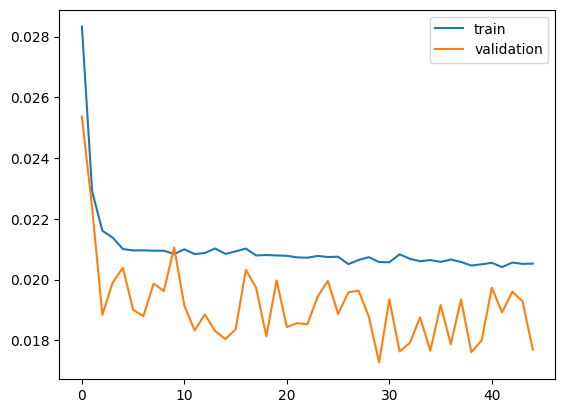

In [10]:
model = build_model(hp)

# fit network
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(train_x,
                    train_y,
                    epochs=200,
                    batch_size=72,
                    validation_data=(test_x, test_y),
                    validation_split=0.3,
                    verbose=2,
                    callbacks=[es],
                    workers=4,
                    use_multiprocessing=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [11]:
predict = model.predict(test_x)

real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

23/23 [==============================] - 1s 5ms/step


Test R2: 0.544
Test MSE: 17858852.609
Test RMSE: 4225.974
Test MAE: 3261.235
Test MAPE: 0.319


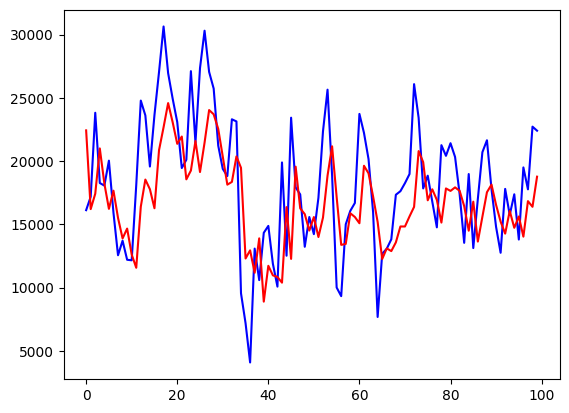

In [12]:
range_plot = 100

pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

pyplot.show()

## Manual Model

In [13]:
print(test_x.shape, test_y.shape)

(728, 5, 3) (728,)


Epoch 1/200
65/65 - 4s - loss: 0.0294 - val_loss: 0.0242 - 4s/epoch - 58ms/step
Epoch 2/200
65/65 - 1s - loss: 0.0247 - val_loss: 0.0234 - 1s/epoch - 16ms/step
Epoch 3/200
65/65 - 1s - loss: 0.0238 - val_loss: 0.0230 - 917ms/epoch - 14ms/step
Epoch 4/200
65/65 - 1s - loss: 0.0235 - val_loss: 0.0234 - 972ms/epoch - 15ms/step
Epoch 5/200
65/65 - 1s - loss: 0.0227 - val_loss: 0.0225 - 978ms/epoch - 15ms/step
Epoch 6/200
65/65 - 1s - loss: 0.0225 - val_loss: 0.0223 - 1s/epoch - 16ms/step
Epoch 7/200
65/65 - 1s - loss: 0.0219 - val_loss: 0.0231 - 934ms/epoch - 14ms/step
Epoch 8/200
65/65 - 1s - loss: 0.0220 - val_loss: 0.0219 - 987ms/epoch - 15ms/step
Epoch 9/200
65/65 - 1s - loss: 0.0215 - val_loss: 0.0241 - 974ms/epoch - 15ms/step
Epoch 10/200
65/65 - 1s - loss: 0.0218 - val_loss: 0.0217 - 1s/epoch - 16ms/step
Epoch 11/200
65/65 - 1s - loss: 0.0215 - val_loss: 0.0223 - 984ms/epoch - 15ms/step
Epoch 12/200
65/65 - 1s - loss: 0.0212 - val_loss: 0.0220 - 1s/epoch - 16ms/step
Epoch 13/200
65/

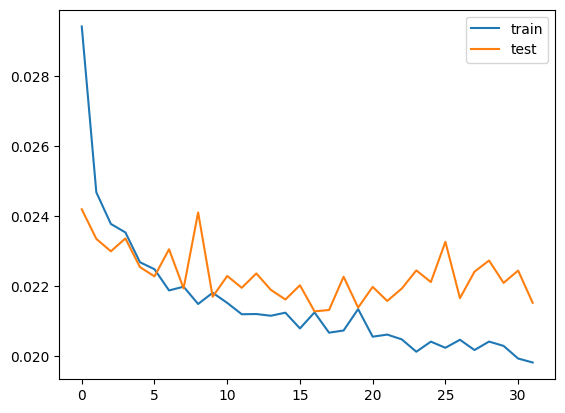

In [17]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping


model2 = Sequential([
    Dense(1, input_shape=(5, 3)),
    Dense(units=352),
    Dropout(rate=0.35),
    LSTM(units=320),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(0.01))

history = model2.fit(train_x,
                     train_y,
                     epochs=200,
                     batch_size=72,
                     #validation_data=(test_x, test_y),
                     validation_split=0.3,
                     verbose=2,
                     callbacks=[es],
                     workers=4,
                     use_multiprocessing=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [1]:
predict = model2.predict(test_x)



real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

NameError: name 'model2' is not defined

Test R2: 0.539
Test MSE: 18073819.328
Test RMSE: 4251.331
Test MAE: 3238.830
Test MAPE: 0.320


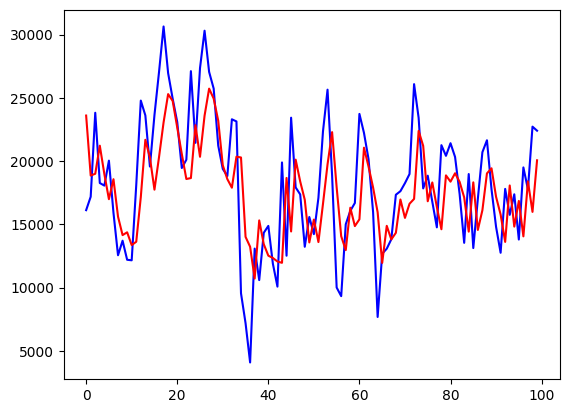

In [19]:
range_plot = 100

pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

pyplot.show()